In [1]:
import numpy  as np
import pandas as pd

import datetime as dtm
import time

import os

import matplotlib.pyplot as plt

# Primera visualización
---

Comenzamos haciendo un breve análisis exploratorio de la base de datos

In [2]:
# Importamos nuestra base de datos
data = %time pd.read_excel("CIB-1922.xlsx", parse_dates=[1])

# Cambiamos los nombres de las columnas
data.columns = ["Datetime", "Sistema", "Nemo", "Descripcion", "Tasa_ref", "P_limpio", "P_sucio",
                "Tasa", "CantidadCOP", "VolumenCOP", "Moneda", "Rueda"]

data = data.drop_duplicates(subset="Datetime", keep="first")

CPU times: user 22.8 s, sys: 80.9 ms, total: 22.9 s
Wall time: 23.7 s


In [3]:
# Vemos cuantas transacciones hay en nuestra base de datos
data.shape

(263981, 12)

In [4]:
def process_data(dat):
    """
    -----------------------------------------------------
    Funcion que filtra los datos: Bonos tasa fija en COP.
    Fija el timestamp como indice
    -----------------------------------------------------
    
    Parametros: dat - Pandas DataFrame
        Datos con las transacciones intradia de los bonos
    
    Return: dat - Pandas DataFrame
        Datos filtrados
    """
    
    # Nos interesan las transacciones del mercado secundario, en COP, tasa fija
    cond = (dat["Sistema"] == "Transaccional") & (dat["Moneda"] == "COP") & (dat["Nemo"].str.contains("TFIT"))
    dat  = dat.loc[cond].copy()
    
    # Inicializamos la columna Dia
    dat['Dia'] = pd.to_datetime(dat['Datetime'], format='%Y:%M:%D').dt.date
    
    # Indexamos los datos a partir de la columna Datetime
    dat.set_index("Datetime", inplace=True)
    dat = dat.between_time('9:30','15:40')
    
    return dat

In [5]:
data = process_data(data)

In [6]:
data.shape

(121992, 12)

In [7]:
data.head()

,Sistema,Nemo,Descripcion,Tasa_ref,P_limpio,P_sucio,Tasa,CantidadCOP,VolumenCOP,Moneda,Rueda,Dia
Datetime,,,,,,,,,,,,
2017-01-02 09:42:39,Transaccional,TFIT06211118,TITULOS TES,FS,97.952,98.527,6.175,5000000000,4.926365e+09,COP,SPOT,2017-01-02
2017-01-02 09:42:44,Transaccional,TFIT06211118,TITULOS TES,FS,97.948,98.523,6.177,5000000000,4.926165e+09,COP,SPOT,2017-01-02
2017-01-02 09:44:55,Transaccional,TFIT06211118,TITULOS TES,FS,97.948,98.523,6.177,4000000000,3.940932e+09,COP,SPOT,2017-01-02
2017-01-02 09:44:59,Transaccional,TFIT06211118,TITULOS TES,FS,97.948,98.523,6.177,4000000000,3.940932e+09,COP,SPOT,2017-01-02
2017-01-02 09:52:23,Transaccional,TFIT06211118,TITULOS TES,FS,97.950,98.525,6.176,4000000000,3.941012e+09,COP,SPOT,2017-01-02


In [8]:
# Vemos cuantas transacciones nos quedan en la base de datos
data.shape

(121992, 12)

# Número de transacciones
---

Nos interesan los títulos más líquidos, y que también sean representativos de la estructura a término

In [9]:
# Contamos la cantidad de transacciones que tiene cada titulo
nemos = pd.DataFrame(data["Nemo"].value_counts())
nemos = nemos.reset_index(drop=False)
nemos.columns = ["Nemo", "NumTransacciones"]
#nemos.index.name = "Nemo"
nemos

,Nemo,NumTransacciones
0,TFIT16240724,92136
1,TFIT15240720,11621
2,TFIT06211118,7553
3,TFIT10040522,3284
4,TFIT06110919,2538
5,TFIT16300632,2065
6,TFIT15260826,1651
7,TFIT08261125,432
8,TFIT16180930,303
9,TFIT11241018,271


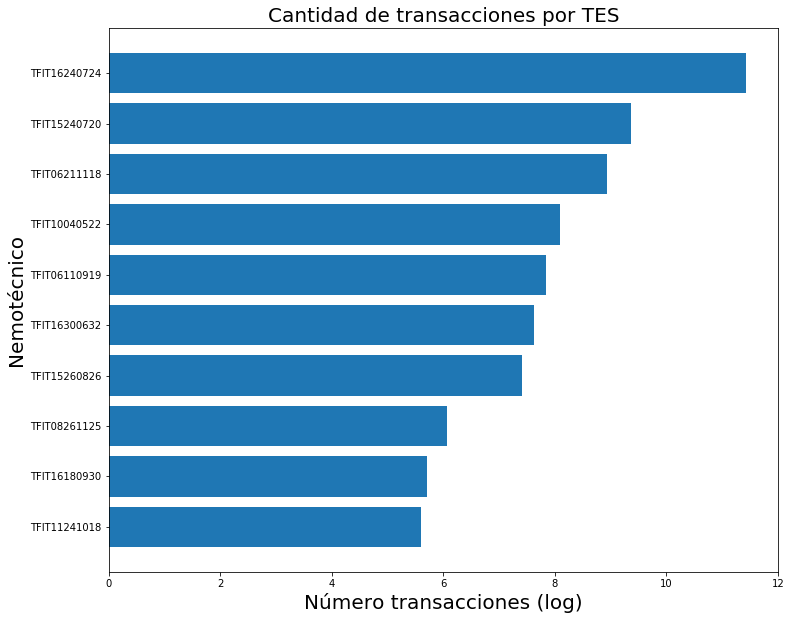

In [10]:
# Ahora contamos el log-numero de transacciones que tiene cada nemotecnico

a = 0
b = -1

y_pos = np.arange(len(nemos["Nemo"].values))[a:b]

#vals = nemos["NumTransacciones"].values[a:b]
# log
vals = np.log(nemos["NumTransacciones"]).values[a:b]
vals = np.flip(vals)
tick = nemos["Nemo"].values[a:b]
tick = np.flip(tick)

plt.figure(figsize=(12, 10))
plt.barh(y_pos, vals, align="center")
plt.yticks(y_pos, tick)

plt.xlabel(r"Número transacciones (log)", fontsize=20)
plt.ylabel(r"Nemotécnico", fontsize=20)
plt.title(r"Cantidad de transacciones por TES", fontsize=20)

plt.show()

## Transacciones diarias
---

Ahora, podemos calcular cuántas transacciones al día hay para cada título.

In [10]:
def daily_transactions(dat):
    """
    --------------------------------------------------
    Funcion que cuenta las transacciones de un bono en
    un dia
    --------------------------------------------------
    Parametros:  dat - Pandas DataFrame
        Datos con las transacciones intradia de los bonos
    
    Return: trans_df - Pandas DataFrame
        Datos de transacciones por dia
    """
    # Guardamos los nemos y dias para los cuales tenemos datos
    nem = dat["Nemo"].drop_duplicates().values
    dia = dat["Dia"].drop_duplicates(keep="first").values
    
    temp_df = []
    start = time.time()
    for n in nem:
        temp = []
        for d in dia:
            cond = (dat["Nemo"]==n) & (dat["Dia"]==d)
            temp.append(len(dat.loc[cond]))
        temp_df.append(pd.DataFrame(data=temp, columns=[n], index=dia))
        
    # Vemos cuanto demora la ejecucion
    print("+--------------------------+")
    print("| Se demoró %.4f minutos |"%((time.time()-start)/60))
    print("+--------------------------+")
    
    trans_df = pd.concat(temp_df, axis=1)
    return trans_df

In [11]:
# Calculamos las transacciones diarias de cada bono
daily_trans = daily_transactions(data)

+--------------------------+
| Se demoró 0.8828 minutos |
+--------------------------+


In [13]:
# Calculamos estadisticas de las transacciones
media   = daily_trans.mean().values
mediana = daily_trans.median().values
nem     = daily_trans.mean().index.tolist()

# Convertimos a dataframe
data_di = {"Mean": media, "Median": mediana}

# Quitamos el titulo que mas transa (outlier)
trans_stats = pd.DataFrame(data_di, index=nem).sort_values(by="Mean", ascending=True).drop(["TFIT16240724"])
#trans_stats

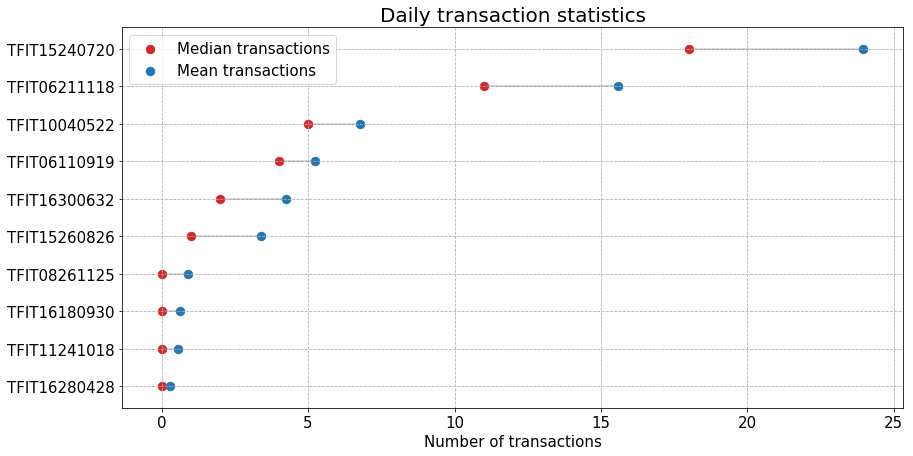

In [14]:
# Graficamos las estadisticas de las transacciones

my_range=range(1,len(trans_stats.index)+1)

plt.figure(figsize=(14, 7))
plt.hlines(y=my_range, xmin=trans_stats['Median'], xmax=trans_stats['Mean'], color='grey', alpha=0.4)
plt.scatter(trans_stats['Median'], my_range, color='C3', alpha=1, label='Median transactions', s=70)
plt.scatter(trans_stats['Mean'], my_range, color='C0', alpha=1 , label='Mean transactions', s=70)
plt.legend(fontsize=15)
plt.grid(linestyle="--")

plt.yticks(my_range, trans_stats.index.tolist(), fontsize=15)
plt.xticks(fontsize=15)
plt.title("Daily transaction statistics", fontsize=20)
plt.xlabel("Number of transactions", fontsize=15)

plt.show()

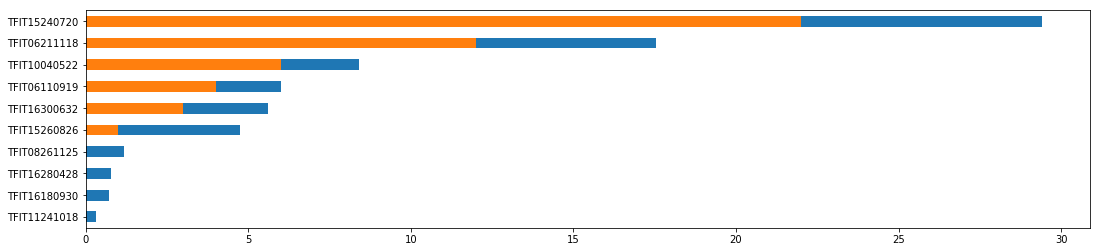

In [210]:
plt.figure(figsize=(18, 4))
daily_trans.mean().drop(["TFIT16240724"]).sort_values().plot(kind="barh")
daily_trans.median().drop(["TFIT16240724"]).sort_values().plot(kind="barh", color="C1")
plt.show()

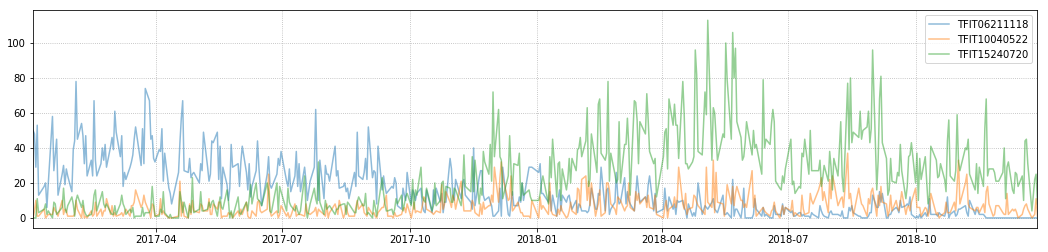

In [15]:
# Graficamos las transacciones diarias

plt.figure(figsize=(18, 4))
daily_trans["TFIT06211118"].plot(label="TFIT06211118", alpha=0.5)
daily_trans["TFIT10040522"].plot(label="TFIT10040522", alpha=0.5)
daily_trans["TFIT15240720"].plot(label="TFIT15240720", alpha=0.5)
#daily_trans["TFIT06110919"].plot(label="TFIT06110919", alpha=0.5)
#daily_trans["TFIT16240724"].plot(marker="o", alpha=0.5)

plt.grid(linestyle=":")
plt.legend(loc="best")
plt.show()

# Tabla 1
---

Ahora calculamos las estadísticas para la tabla de selección de datos

In [78]:
# Guardamos los valores de los nemotecnicos
#nem = nemos["Nemo"].values

In [16]:
# Guardamos los valores de los nemotecnicos
nem = nemos["Nemo"].values

# Guardamos los dias para los cuales tenemos datos
dia = data["Dia"].drop_duplicates(keep="first").values

# Creamos el diccionario en donde guardaremos los datos
trans = dict()
start = time.time()
for n in nem:
    temp = []
    for d in dia:
        # Nos quedamos con el numero de transacciones que el titulo n tiene en el dia d
        cond = (data["Nemo"]==n) & (data["Dia"]==d)
        temp.append(len(data.loc[cond]))
    # Guardamos el resultado como un DataFrame
    trans[n] = pd.DataFrame(temp, columns=[n], index=dia)

# Vemos cuanto demora la ejecucion
print("+--------------------------+")
print("| Se demoró %.4f minutos |"%((time.time()-start)/60))
print("+--------------------------+")

+--------------------------+
| Se demoró 0.7986 minutos |
+--------------------------+


In [7]:
len(dia)

485

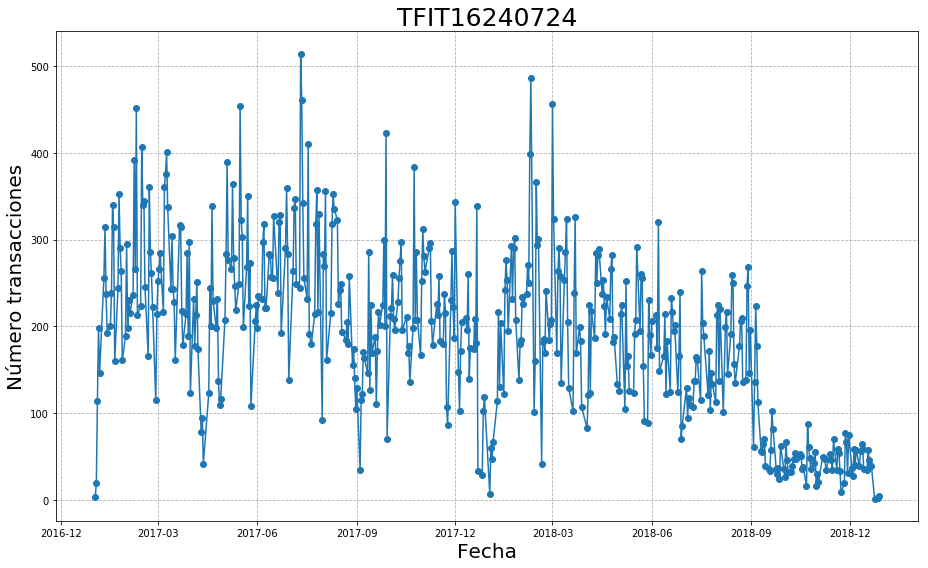

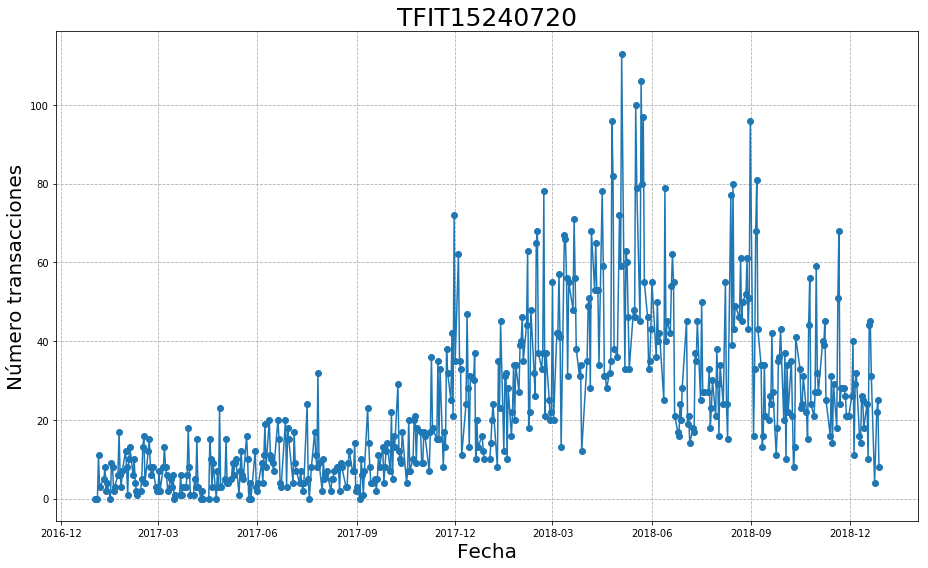

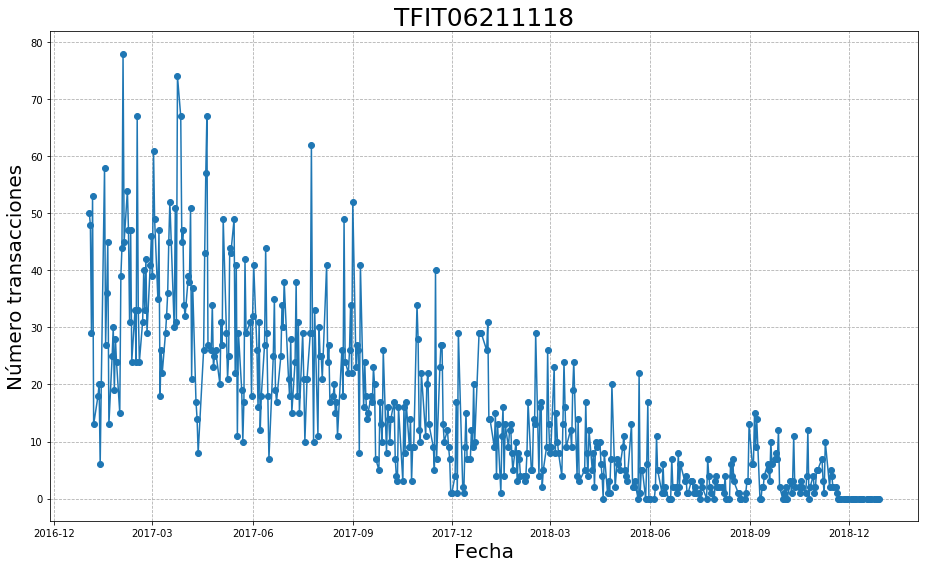

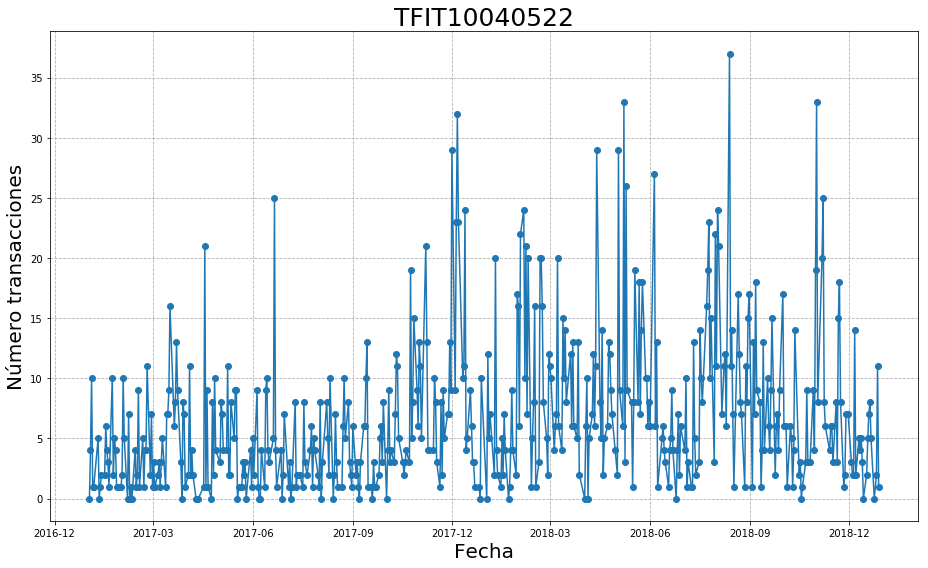

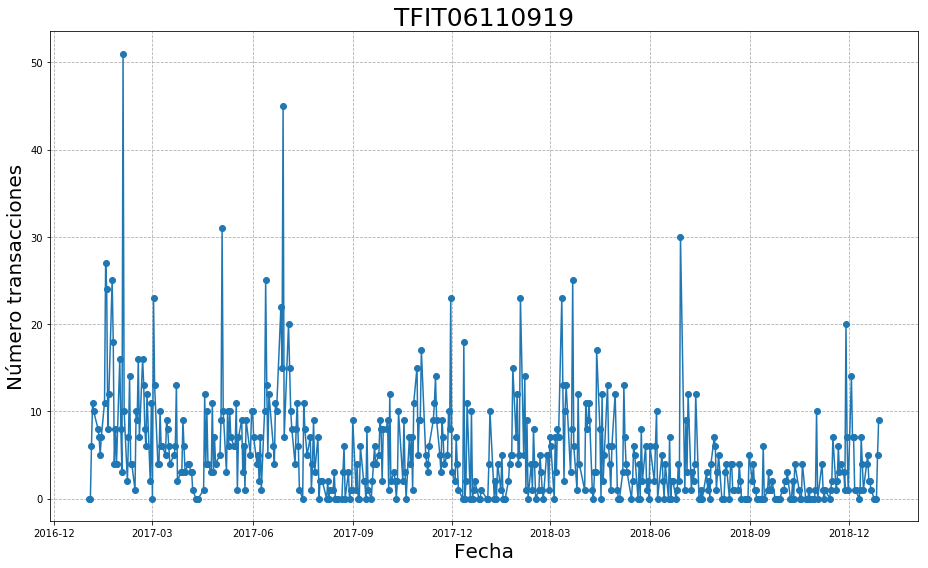

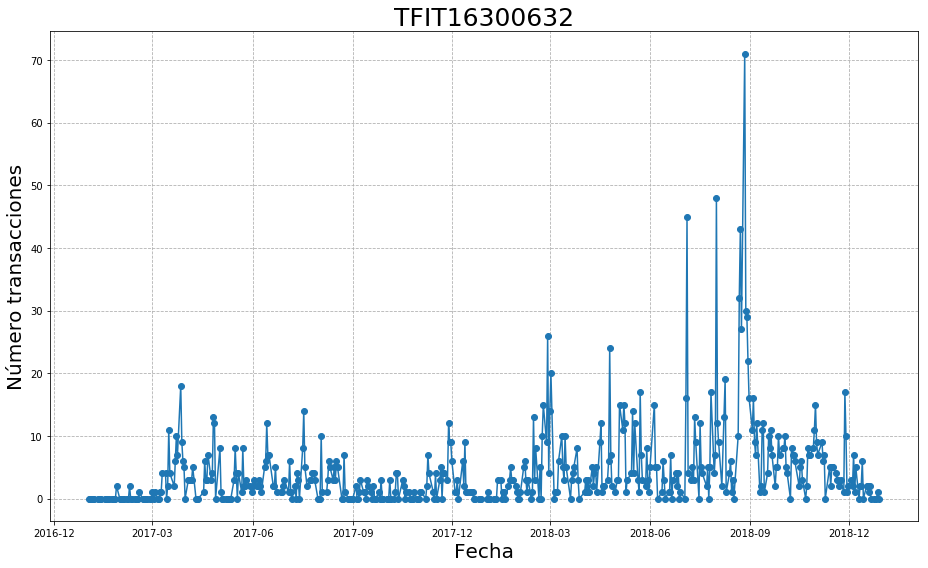

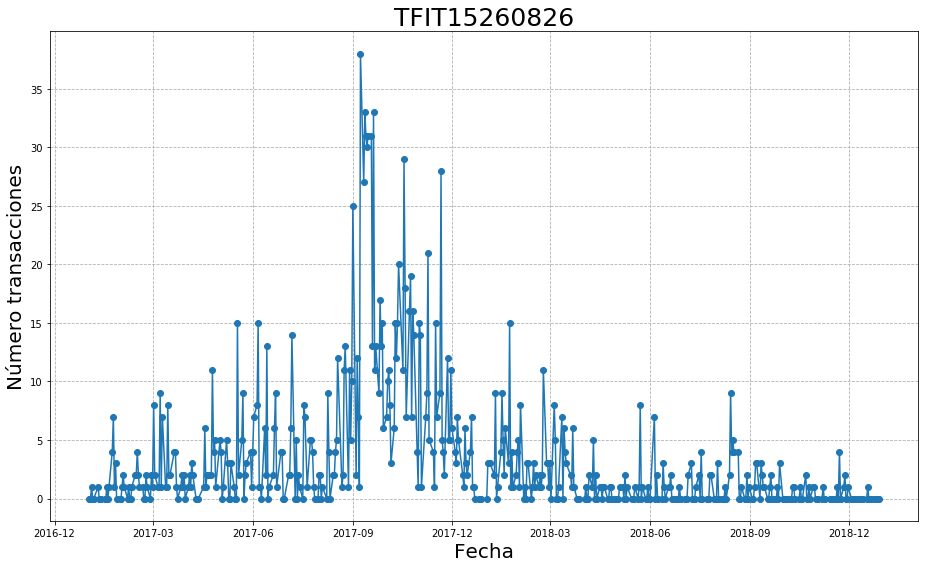

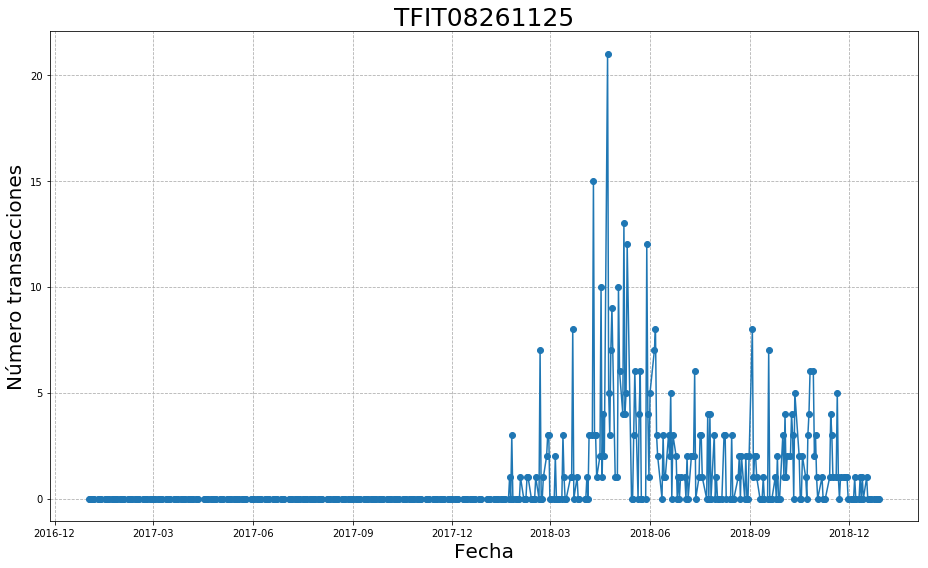

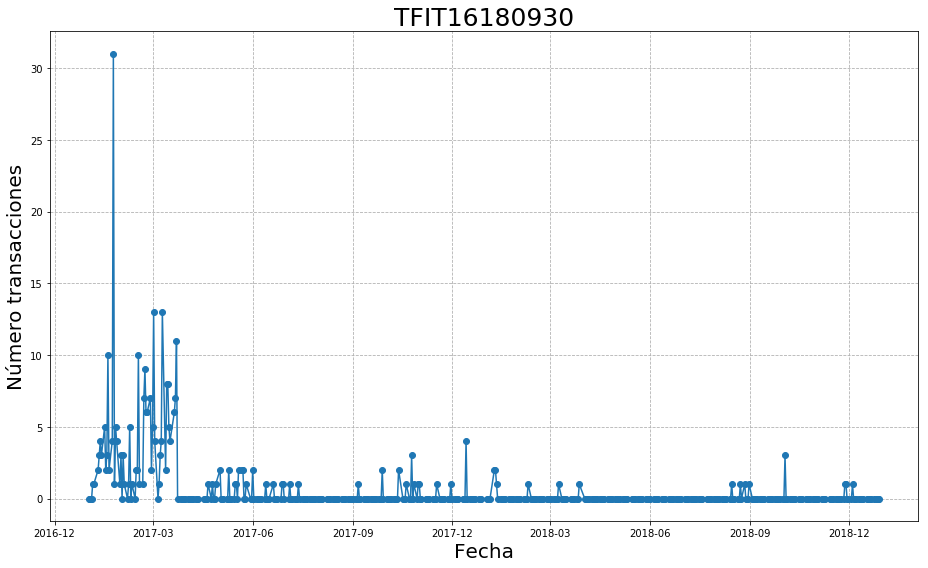

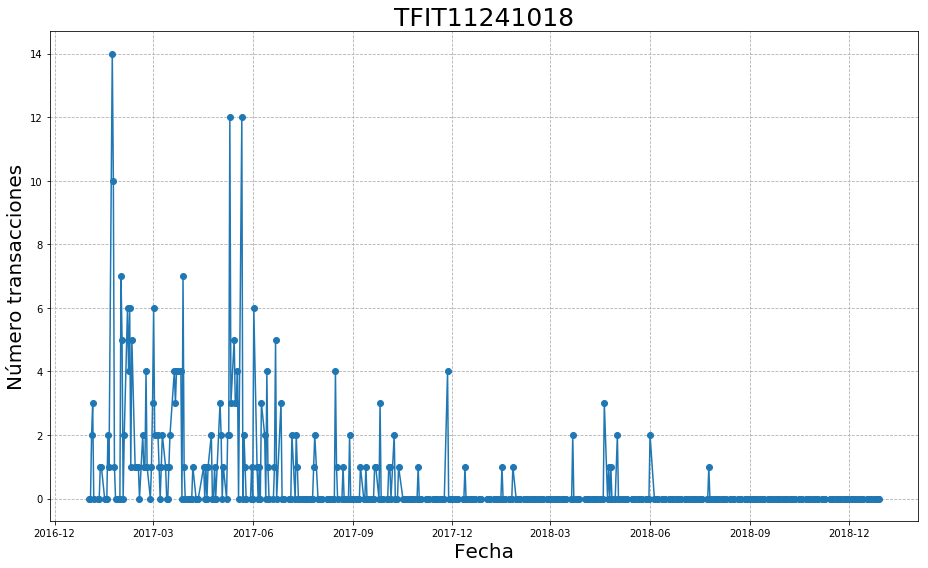

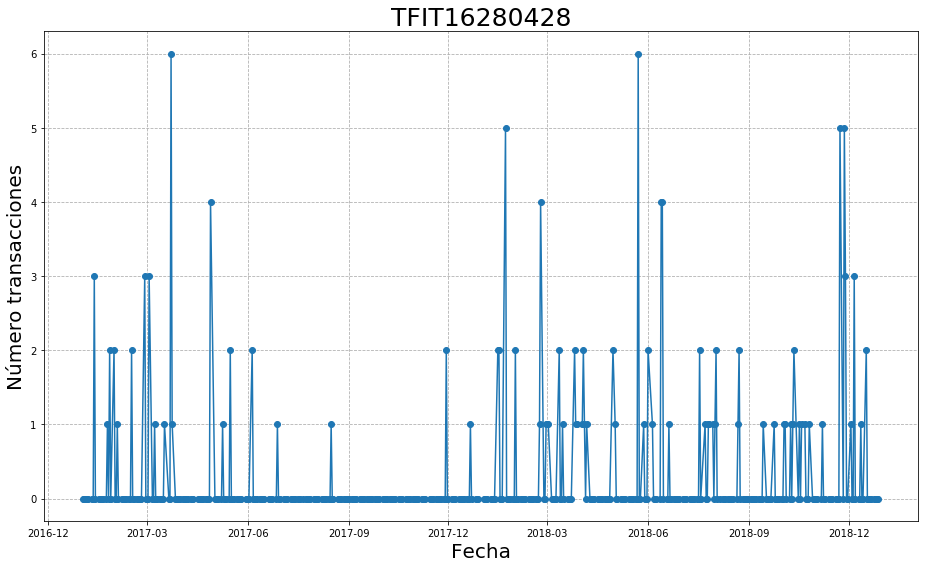

In [36]:
# Definimos una ruta donde guardaremos las imagenes
DIRECTORY  = "NumTrans"
PARENT_DIR = os.getcwd()
PATH       = os.path.join(PARENT_DIR, DIRECTORY)

# Creamos el directorio donde guardaremos las imagenes
#os.mkdir(PATH) # Si el directorio ya existe este comando bota error

# Graficamos el conteo de las transacciones de cada titulo
#plt.figure(figsize=(13, 8)) # Para grafica UNIFICADA
#del trans["TFIT16240724"]   # Para grafica UNIFICADA - se elimina el titulo mas liquido
for k in trans.keys():
    
    plt.figure(figsize=(13, 8))                # Para graficas individuales
    plt.plot(dia, trans[k].values[:,0], marker="o")
    
    plt.title(k, fontsize=25)
    plt.xlabel("Fecha", fontsize=20)
    plt.ylabel("Número transacciones", fontsize=20)
    
    plt.grid(linestyle="--")
    
    plt.tight_layout()
    #ROUTE = PATH + "/num_trans_" + k + ".pdf" # Para graficas individuales
    #plt.savefig(ROUTE)                        # Para graficas individuales
    plt.show()
    plt.close("all")
#plt.show()                  # Para grafica UNIFICADA
#plt.savefig(PATH)           # Para graficas UNIFICADA

In [17]:
years = [2017, 2018]
tab1  = []

nemo_list = []
trans_avg = []
trans_med = []

# Estadisticas totales
for k in trans.keys():
    nemo_list.append(k)
    trans_avg.append(np.mean(trans[k].values))
    trans_med.append(np.median(trans[k]))
    
# Guardamos los resultados
stats_df = pd.DataFrame({"Trans_promedio": trans_avg, 
                         "Mediana": trans_med}, 
                         index=nemo_list)
tab1.append(stats_df)

# Estadisticas por año
for y in years:
    # Reiniciamos los calculos para cada año
    nemo_list = []
    trans_avg = []
    trans_med = []
    
    # Calculamos las estadisticas para cada titulo
    for k in trans.keys():
        
        # Separamos el diccionario por titulo
        df = trans[k].reset_index().copy()
        df.columns = ["Date", k]
        
        # Separamos el dataframe por fecha
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df_y = df[df["Date"].dt.year == y]
        
        # Calculamos las estadisticas
        nemo_list.append(k)
        trans_avg.append(np.mean(df_y[k].values))
        trans_med.append(np.median(df_y[k]))
        
    # Guardamos los resultados y convertimos a dataframe
    stats_df = pd.DataFrame({"Trans_promedio"+str(y): trans_avg, 
                             "Mediana"+str(y): trans_med}, 
                             index=nemo_list)
    tab1.append(stats_df)
    
# Unificamos resultados
stats_df = pd.concat(tab1, axis=1)

stats_df

,Trans_promedio,Mediana,Trans_promedio2017,Mediana2017,Trans_promedio2018,Mediana2018
TFIT16240724,189.971134,198.0,233.636364,226.0,146.485597,137.0
TFIT15240720,23.960825,18.0,10.462810,8.0,37.403292,34.0
TFIT06211118,15.573196,11.0,25.727273,24.0,5.460905,4.0
TFIT10040522,6.771134,5.0,5.095041,4.0,8.440329,7.0
TFIT06110919,5.232990,4.0,6.710744,5.5,3.761317,2.0
TFIT16300632,4.257732,2.0,2.243802,1.0,6.263374,4.0
TFIT15260826,3.404124,1.0,5.500000,2.0,1.316872,0.0
TFIT08261125,0.890722,0.0,0.000000,0.0,1.777778,1.0
TFIT16180930,0.624742,0.0,1.177686,0.0,0.074074,0.0
TFIT11241018,0.558763,0.0,1.061983,0.0,0.057613,0.0


# Calculamos tiempos inter-arrivo

In [24]:
def inter_times(bonddata, nemo):
    """
    ----------------------------------------
    Funcion que calcula tiempos inter-arribo
    ----------------------------------------
    
    Parametros:
        bonddata: Pandas DataFrame
            DataFrame de los datos con transacciones intradia de
            bonos
        nemo: list
            Lista con los nemos de los bonos a analizar
            
    Return:
        df: Pandas DataFrame
            DataFrame con columna de tiempos inter-arribo
    """
    def it_calc(bonddata, nm):
        # Nos quedamos con los datos del título que nos interesa
        df   = bonddata.loc[bonddata["Nemo"]==nm].reset_index()
        diff = df.reset_index().groupby(pd.Grouper(key='Datetime', freq='1D')).Datetime.diff()
        df["InterTimes"] = diff
        return df.set_index("Datetime")
    
    temp = []
    start = time.time()
    for n in nemo:
        temp.append(it_calc(data, n))
    
    # Vemos cuanto demora
    print("+--------------------------+")
    print("| Se demoró %.4f minutos |"%((time.time()-start)/60))
    print("+--------------------------+")
    
    df = pd.concat(temp)
    return df

In [19]:
data = inter_times(data, nem)

+--------------------------+
| Se demoró 0.0453 minutos |
+--------------------------+


In [23]:
data.head()

,Sistema,Nemo,Descripcion,Tasa_ref,P_limpio,P_sucio,Tasa,CantidadCOP,VolumenCOP,Moneda,Rueda,Dia,InterTimes
Datetime,,,,,,,,,,,,,
2017-01-02 10:07:15,Transaccional,TFIT16240724,TITULOS TES,FS,118.029,122.467,6.850,500000000,6.123370e+08,COP,SPOT,2017-01-02,NaT
2017-01-02 12:35:40,Transaccional,TFIT16240724,TITULOS TES,FS,117.965,122.403,6.860,500000000,6.120170e+08,COP,SPOT,2017-01-02,02:28:25
2017-01-02 13:01:17,Transaccional,TFIT16240724,TITULOS TES,FS,117.965,122.403,6.860,1500000000,1.836051e+09,COP,SPOT,2017-01-02,00:25:37
2017-01-02 13:01:18,Transaccional,TFIT16240724,TITULOS TES,FS,117.965,122.403,6.860,1500000000,1.836051e+09,COP,SPOT,2017-01-02,00:00:01
2017-01-03 09:31:55,Transaccional,TFIT16240724,TITULOS TES,FS,117.863,122.328,6.875,1000000000,1.223288e+09,COP,SPOT,2017-01-03,NaT


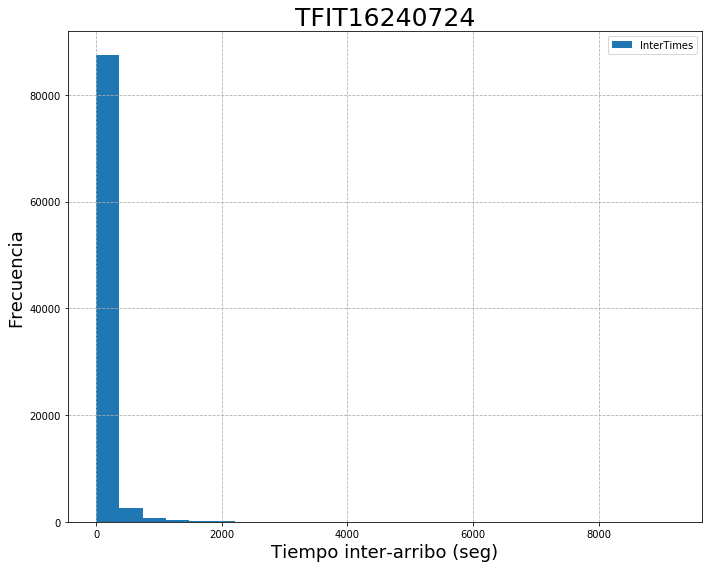

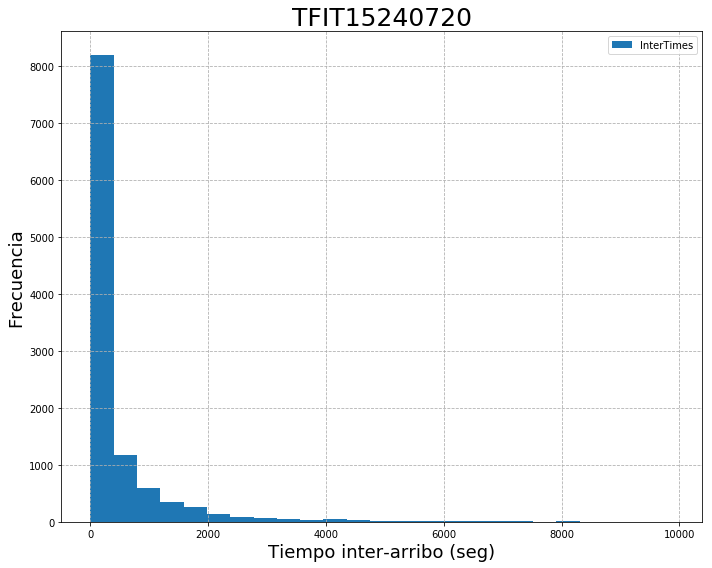

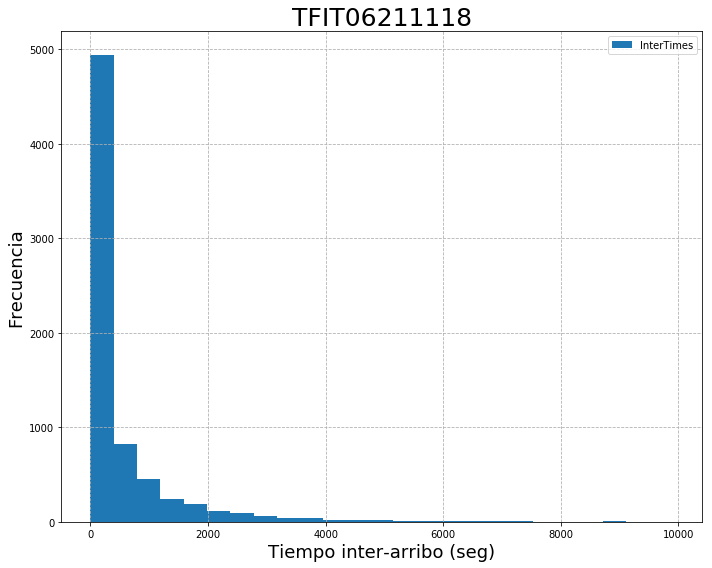

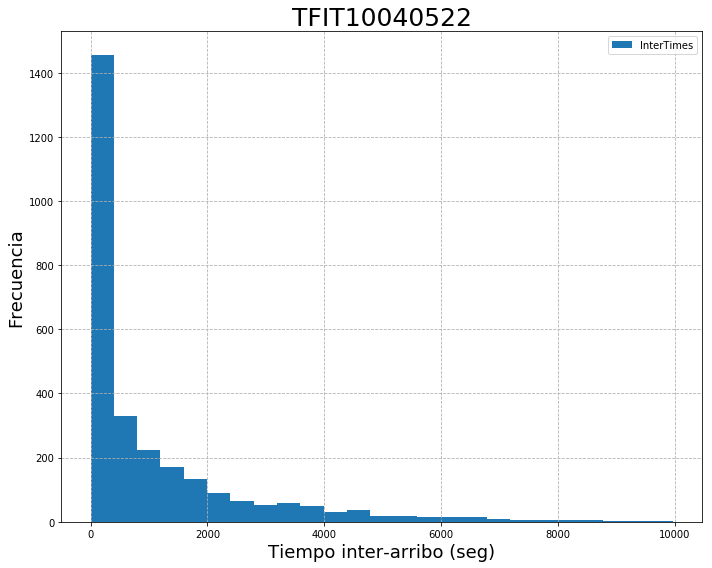

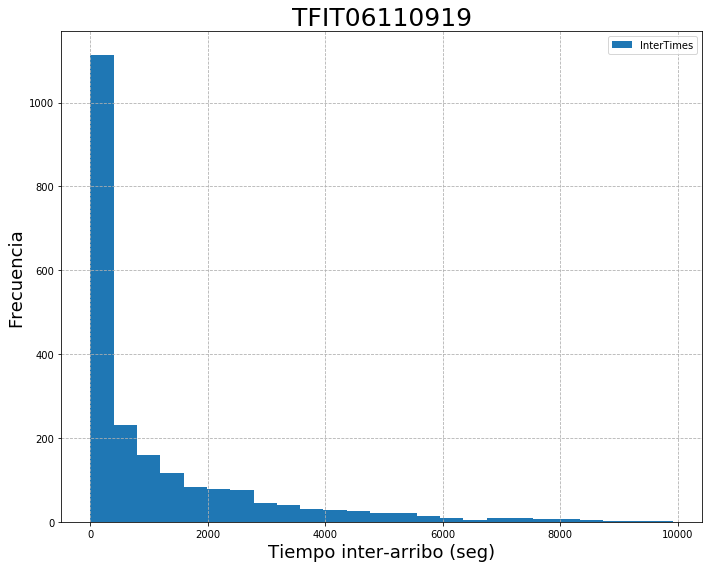

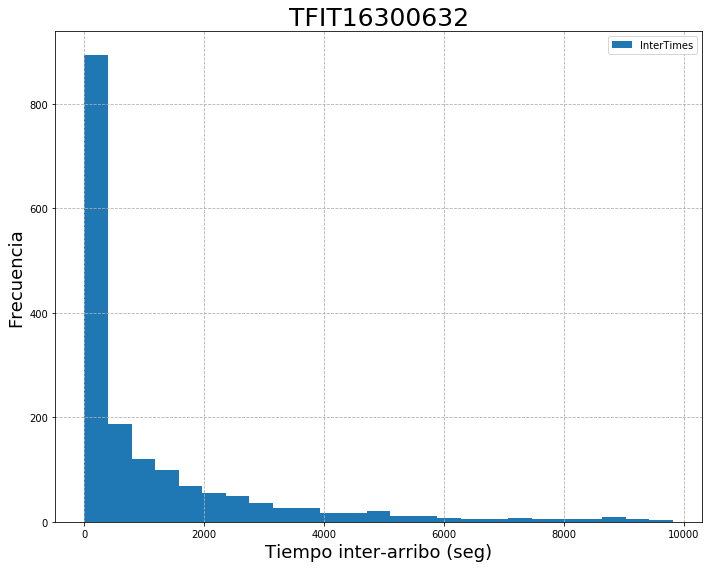

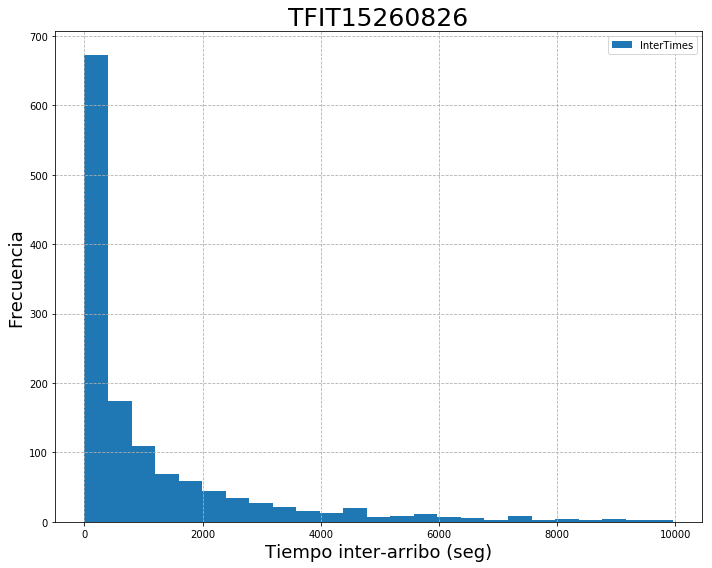

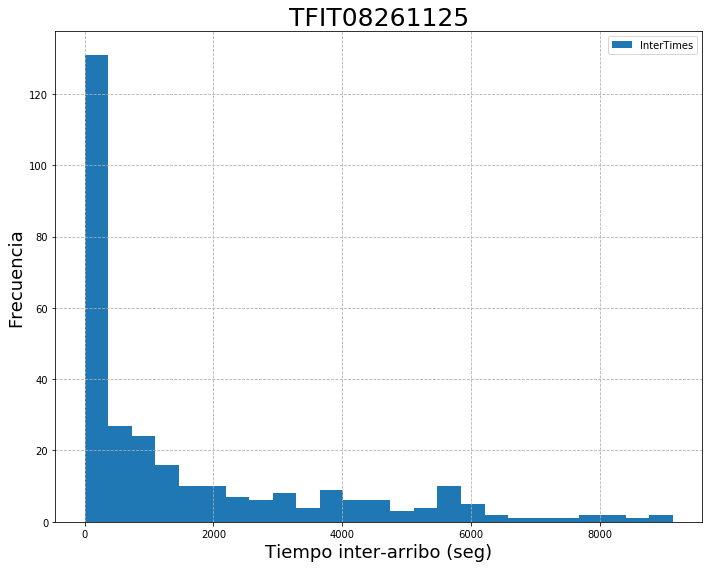

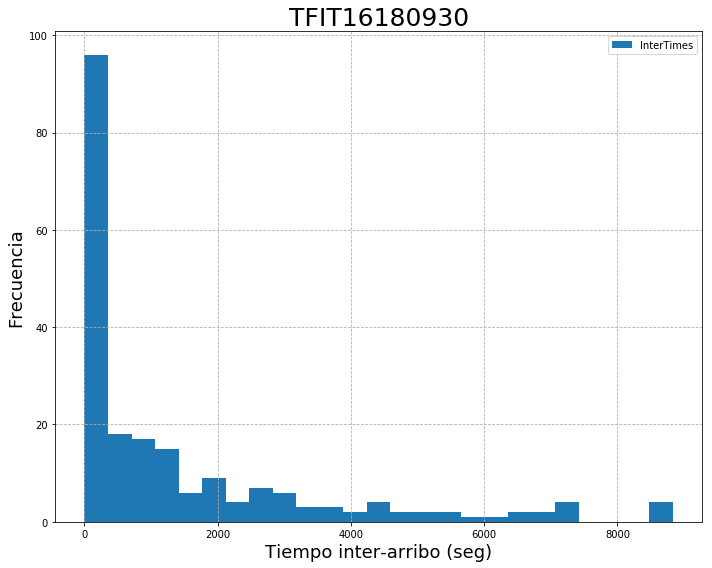

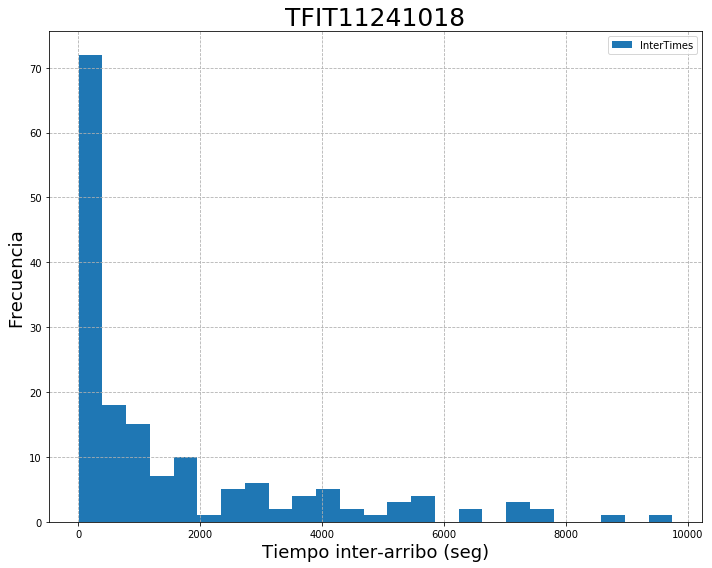

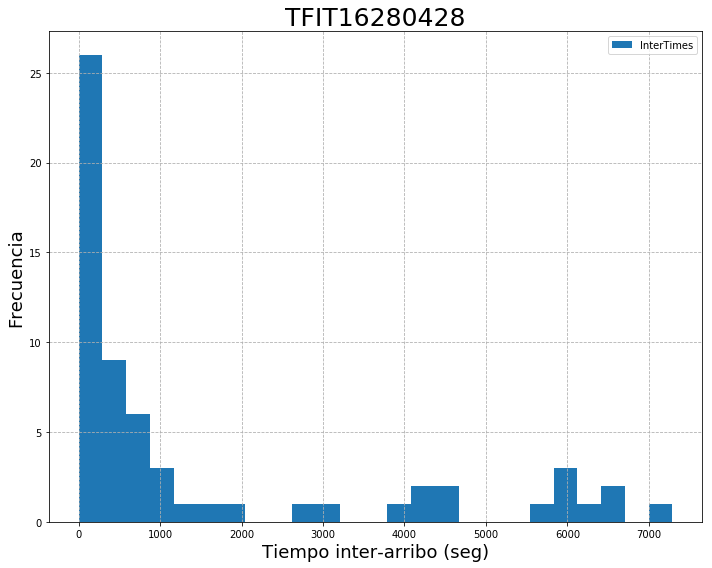

In [43]:
# Definimos una ruta donde guardaremos las imagenes
DIRECTORY  = "InterTimes"
PARENT_DIR = os.getcwd()
PATH       = os.path.join(PARENT_DIR, DIRECTORY)

# Creamos el directorio donde guardaremos las imagenes
#os.mkdir(PATH) # Si el directorio ya existe este comando bota error

for n in nem:
    # Escogemos los datos para cada nemo
    temp = pd.DataFrame(data.loc[data["Nemo"]==n]["InterTimes"].copy()).dropna()
    temp = temp.loc[temp["InterTimes"]<=pd.Timedelta(10000, "s")]
    temp.astype('timedelta64[s]').plot.hist(figsize=(10, 8), align="mid", bins=25)
    
    # Parametros de las graficas
    plt.title(n, fontsize=25)
    plt.xlabel("Tiempo inter-arribo (seg)", fontsize=18)
    plt.ylabel("Frecuencia", fontsize=18)
    plt.tick_params
    plt.grid(linestyle="--")
    plt.tight_layout()
    
    # Ruta de almacenamiento
    #ROUTE = PATH + "/intertimes_" + n + ".pdf"
    #plt.savefig(ROUTE)
    plt.show()

# Tabla 2
---

Estadísticas de los tiempos inter-arribo

In [25]:
# Calculamos las estadisticas necesarias para la tabla de tiempo inter-arribo

years = [2017, 2018]
tab2  = []

nemo_list = []
inter_avg = []
inter_med = []

# Estadisticas totales
for n in nem:
    
    # Separamos el dataframe por titulo
    df = pd.DataFrame(data.loc[data["Nemo"]==n][["InterTimes"]]).reset_index()
    df.columns = ["Datetime", "InterTimes"]
    
    # Convertimos Datetime al formato correspondiente
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df_y = df["InterTimes"]
    
    # Calculamos las estadisticas
    nemo_list.append(n)
    inter_avg.append(df_y.mean(numeric_only=False))
    inter_med.append(df_y.median(numeric_only=False))

# Guardamos los resultados
stats_df = pd.DataFrame({"intertime_avg": inter_avg, 
                         "median": inter_med}, 
                         index=nemo_list)
tab2.append(stats_df)

# Estadisticas por año
for y in years:
    # Reiniciamos los calculos para cada año
    nemo_list = []
    inter_avg = []
    inter_med = []
    
    # Calculamos las estadisticas para cada titulo
    for n in nem:
        
        # Separamos el diccionario por titulo
        df = pd.DataFrame(data.loc[data["Nemo"]==n][["InterTimes"]]).reset_index()
        df.columns = ["Datetime", "InterTimes"]
        
        # Separamos el dataframe por fecha
        df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
        df_y = df[df["Datetime"].dt.year == y]["InterTimes"]
        
        # Calculamos las estadisticas
        nemo_list.append(n)
        inter_avg.append(df_y.mean(numeric_only=False))
        inter_med.append(df_y.median(numeric_only=False))
        
    # Guardamos los resultados y convertimos a dataframe
    stats_df = pd.DataFrame({"intertime_avg"+str(y): inter_avg, 
                             "median"+str(y): inter_med}, 
                             index=nemo_list)
    tab2.append(stats_df)
    
# Unificamos resultados
stats_df = pd.concat(tab2, axis=1)

stats_df

,intertime_avg,median,intertime_avg2017,median2017,intertime_avg2018,median2018
TFIT16240724,00:01:29.046917,00:00:13,00:01:15.378414,00:00:12,00:01:50.813368,00:00:14
TFIT15240720,00:07:18.138039,00:01:16,00:14:47.167173,00:04:17,00:05:21.236151,00:00:58
TFIT06211118,00:08:32.519527,00:01:40.500000,00:07:09.707720,00:01:24,00:15:49.508818,00:04:44.500000
TFIT10040522,00:18:42.474019,00:05:56,00:22:04.609081,00:07:39,00:16:49.719162,00:05:07
TFIT06110919,00:19:24.302705,00:05:46,00:19:19.943971,00:05:51.500000,00:19:32.675749,00:05:34.500000
TFIT16300632,00:20:04.405137,00:05:35,00:26:43.930174,00:09:17,00:18:02.294207,00:05:16.500000
TFIT15260826,00:19:42.870508,00:06:35,00:17:23.906607,00:05:33,00:32:47.567164,00:16:57
TFIT08261125,00:27:06.658862,00:09:30,NaT,NaT,00:27:06.658862,00:09:30
TFIT16180930,00:24:55.545023,00:07:36,00:24:21.120772,00:07:08,00:54:37,00:45:56.500000
TFIT11241018,00:27:40.795180,00:10:25.500000,00:27:38.962732,00:10:27,00:28:39.800000,00:03:42


# Calculamos las madureces

In [26]:
def get_maturity(bonddata, init=2017, fin=2019):
    """
    -------------------------------------------
    Funcion que calcula la madurez de los bonos
    -------------------------------------------
    
    Parametros:
        bonddata: Pandas DataFrame
            DataFrame de los datos con transacciones intradia de
            bonos
        init, fin: int
            Rango de fechas: [año inicial, año final+1]
            
    Return:
        bonddata: Pandas DataFrame
            DataFrame con columna de madurez
    """
    
    # Inicializamos dos columnas que seran insumos para calcular la madurez:
    # Año expiracion
    bonddata["Exp_yr"]  = np.zeros(len(bonddata))
    # Año actual
    bonddata["Curr_yr"] = np.zeros(len(bonddata))
    
    # Guardamos los años de expiracion para los titulos de nuestra muestra
    for nemo in np.unique(bonddata["Nemo"].values):
        
        # Vemos el año de expiracion y agregamos el prefijo "20"
        exp_year = int("20"+nemo[-2:])
        
        # Creamos la columna "Exp_yr" segun el nombre del titulo
        bonddata.loc[bonddata["Nemo"] == nemo, ["Exp_yr"]] = exp_year
        
    # Recorremos los años para los cuales tenemos datos
    for year in range(init, fin):
        
        # Nos quedamos con las fechas del año "year"
        cond = bonddata["Dia"].astype(str).str.contains(str(year))
        
        # Guardamos el año actual en la columna correspondiente
        bonddata.loc[cond, ["Curr_yr"]] = year
        
    # Calculamos las madureces
    bonddata["Madurez"] = bonddata["Exp_yr"].values - bonddata["Curr_yr"].values
    
    # Eliminamos posibles errores
    #bonddata.loc[bonddata["Madurez"] <0]
    
    # Eliminamos las columnas temporales
    bonddata = bonddata.drop(["Exp_yr", "Curr_yr"], axis=1)
    
    return bonddata

In [27]:
maturities = %time get_maturity(data)

CPU times: user 302 ms, sys: 15 µs, total: 302 ms
Wall time: 301 ms


# Madureces
---
Vamos a ver a cuántas transacciones hay para cada madurez. Supongo que tendremos que segmentar la curva por corto, mediano y largo plazo debido a la escazes de los datos.

In [28]:
maturities.shape

(121992, 14)

In [29]:
# Vemos el numero de transacciones segun la madurez
num_trans = pd.DataFrame(maturities["Madurez"].value_counts())
num_trans = num_trans.reset_index()
num_trans.columns = ["Madurez", "NumTransacciones"]
#num_trans.sort_values("Madurez")
num_trans

,Madurez,NumTransacciones
0,7.0,56972
1,6.0,35596
2,2.0,10713
3,1.0,7397
4,3.0,2532
5,4.0,2051
6,14.0,1522
7,0.0,1341
8,9.0,1331
9,5.0,1233


# Estadístico de salto
---

Realizamos el ejercicio del cálculo del estadístico de salto

In [30]:
from JumpStatistic import *

In [50]:
test = %time JS(maturities.loc[maturities["Nemo"]=="TFIT16240724"], "5T")

/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: divide by zero encountered in log
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: invalid value encountered in double_scalars
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:177: RuntimeWarning: invalid value encountered in double_scalars
  temp = tp/(bv*bv)


CPU times: user 5.38 s, sys: 8 ms, total: 5.39 s
Wall time: 5.47 s


/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:194: RuntimeWarning: invalid value encountered in greater_equal
  crit_val = (np.array(js_result) >= 1.).astype(int)


In [51]:
test.head()

,JS_statistic,OverCritValue
2017-01-02,NaN,0
2017-01-03,6.894548,1
2017-01-04,0.974195,0
2017-01-05,0.166919,0
2017-01-06,-0.183883,0


## Frecuencia de saltos
---
Vamos a estudiar la proporción de días en los que hay saltos en nuestra muestra

In [36]:
def jump_day_freq(bonddata, nemo, frqncy):
    """
    -----------------------------------------------------------
    Funcion que calcula la *cantidad* y *proporcion* de dias en 
    los cuales hay saltos
    -----------------------------------------------------------
    
    Parametros:
        bonddata: Pandas DataFrame
            DataFrame de los datos con transacciones intradia de
            bonos
        nemo, frqncy: list
            Listas con los nemos de los bonos a estudiar y 
            frecuencias de resampleo de datos
    """
    jump_freq = []
    jump_days = []
    start = time.time()
    for n in nemo:
        freq_list = []
        stat_list = []
        jump_nums = []
        print("Nemo "+n)
        for f in frqncy:
            print("--Frecuencia "+f)
            # Calculamos la frecuencia de aceptacion del estadistico
            try:
                df   = JS(bonddata.loc[bonddata["Nemo"]==n], f)
                over = df["OverCritValue"].sum(axis=0, skipna=True)
                undr = df.shape[0]
                
            except Exception:
                over = 0.
                undr = 1.
                
                print("----No se calculó el estadístico para: " + f + "-" + n)
                #print(df)
                pass
            
            # Guardamos los resultados
            freq_list.append(f)
            stat_list.append(over/undr)
            jump_nums.append(over)
            
        # Guardamos los dias con saltos de cada bono
        out = pd.DataFrame({n: jump_nums}, index=freq_list)
        jump_days.append(out)
        
        # Convertimos resultados a dataframe
        out = pd.DataFrame({n: stat_list}, index=freq_list)
        jump_freq.append(out)
    
    # Vemos cuanto demora
    print("+--------------------------+")
    print("| Se demoró %.4f minutos |"%((time.time()-start)/60))
    print("+--------------------------+")
    
    # Unificamos resultados de dias de saltos
    jump_days = pd.concat(jump_days, axis=1)
    # Unificamos los resultados
    jump_freq = pd.concat(jump_freq, axis=1)
    
    return jump_days, jump_freq

In [37]:
# Guardamos los valores de los nemotecnicos
nem = nemos["Nemo"].values
# Creamos la lista de frecuencias que queremos recorrer
frq  = ["5T", "10T", "15T", "20T", "30T"]

jump_days, jump_freq = jump_day_freq(maturities, nem, frq)

Nemo TFIT16240724
--Frecuencia 5T


/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: divide by zero encountered in log
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: invalid value encountered in double_scalars
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:177: RuntimeWarning: invalid value encountered in double_scalars
  temp = tp/(bv*bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:194: RuntimeWarning: invalid value encountered in greater_equal
  crit_val = (np.array(js_result) >= 1.).astype(int)


--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT15240720
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT06211118
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT10040522
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT06110919
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT16300632
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT15260826
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT08261125
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT16180930
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT11241018
--Frecuencia 5T
--Frecuencia 10T
--Frecuencia 15T
--Frecuencia 20T
--Frecuencia 30T
Nemo TFIT16280

In [38]:
# Visualizamos resultados
jump_freq

,TFIT16240724,TFIT15240720,TFIT06211118,TFIT10040522,TFIT06110919,TFIT16300632,TFIT15260826,TFIT08261125,TFIT16180930,TFIT11241018,TFIT16280428
5T,0.556701,0.684322,0.622989,0.351648,0.340102,0.275568,0.241270,0.172932,0.141304,0.095238,0.080000
10T,0.272165,0.605932,0.567816,0.417582,0.365482,0.303977,0.285714,0.203008,0.184783,0.190476,0.106667
15T,0.245361,0.546610,0.494253,0.410989,0.411168,0.306818,0.247619,0.187970,0.184783,0.190476,0.106667
20T,0.173196,0.455508,0.475862,0.452747,0.413706,0.338068,0.276190,0.233083,0.228261,0.180952,0.093333
30T,0.140206,0.368644,0.386207,0.426374,0.398477,0.318182,0.292063,0.240602,0.173913,0.190476,0.066667


In [39]:
# Descartamos los titulos mas iliquidos
drop_cols = ["TFIT11241018", "TFIT08261125", "TFIT16280428", "TFIT15260826", "TFIT16180930"]
jump_days = jump_days.drop(drop_cols, axis=1)
jump_days

,TFIT16240724,TFIT15240720,TFIT06211118,TFIT10040522,TFIT06110919,TFIT16300632
5T,270,323,271,160,134,97
10T,132,286,247,190,144,107
15T,119,258,215,187,162,108
20T,84,215,207,206,163,119
30T,68,174,168,194,157,112


In [40]:
# Descartamos los titulos mas iliquidos
jump_freq = jump_freq.drop(drop_cols, axis=1)
jump_freq

,TFIT16240724,TFIT15240720,TFIT06211118,TFIT10040522,TFIT06110919,TFIT16300632
5T,0.556701,0.684322,0.622989,0.351648,0.340102,0.275568
10T,0.272165,0.605932,0.567816,0.417582,0.365482,0.303977
15T,0.245361,0.546610,0.494253,0.410989,0.411168,0.306818
20T,0.173196,0.455508,0.475862,0.452747,0.413706,0.338068
30T,0.140206,0.368644,0.386207,0.426374,0.398477,0.318182


In [41]:
# Redefinimos la lista de titulos que nos interesan
nem = jump_freq.columns.tolist()
nem

['TFIT16240724',
 'TFIT15240720',
 'TFIT06211118',
 'TFIT10040522',
 'TFIT06110919',
 'TFIT16300632']

## Aplicamos el estadístico a los títulos filtrados

In [44]:
def apply_JS(bonddata, nemo, frqncy):
    """
    -----------------------------------------------------------
    Funcion que aplica el estadistico de salto a los bonos para
    todas las frecuencias
    -----------------------------------------------------------
    
    Parametros:
        bonddata: Pandas DataFrame
            DataFrame de los datos con transacciones intradia de
            bonos
        nemo, frqncy: list
            Listas con los nemos de los bonos a estudiar y 
            frecuencias de resampleo de datos
    
    Return:
        JS_data: dict
            Diccionario que contiene el valor del estadistico de
            salto en proporcion de excedencia del valor critico
            a 95% de confianza. Cada llave del diccionario 
            corresponde a cada frecuencia de resampleo dada en
            la lista frqncy
    """
    
    JS_data = dict()
    start   = time.time()
    for f in frqncy:
        temp_JS = []
        for n in nemo:
            js   =  JS(bonddata.loc[bonddata["Nemo"]==n], f)["JS_statistic"]
            temp = {n: js}
            temp_JS.append( pd.DataFrame(temp) )
        
        JS_data[f] = pd.concat(temp_JS, axis=1, sort=True)
    
    # Vemos cuanto demora
    print("+--------------------------+")
    print("| Se demoró %.4f minutos |"%((time.time()-start)/60))
    print("+--------------------------+")
    
    return JS_data

In [45]:
JS_data = apply_JS(maturities, nem, frq)

/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: divide by zero encountered in log
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:171: RuntimeWarning: invalid value encountered in double_scalars
  num = np.log(rv) - np.log(bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:177: RuntimeWarning: invalid value encountered in double_scalars
  temp = tp/(bv*bv)
/home/nromerodiaz93/Documents/Universidad/Tesis/Datos/JumpStatistic.py:194: RuntimeWarning: invalid value encountered in greater_equal
  crit_val = (np.array(js_result) >= 1.).astype(int)


+--------------------------+
| Se demoró 1.8877 minutos |
+--------------------------+


**Figura 1:** Resultados del estadístico de saltos.

Esta imagen va a ser la figura 1 del documento de tesis. Se incluye en la sección de resultados

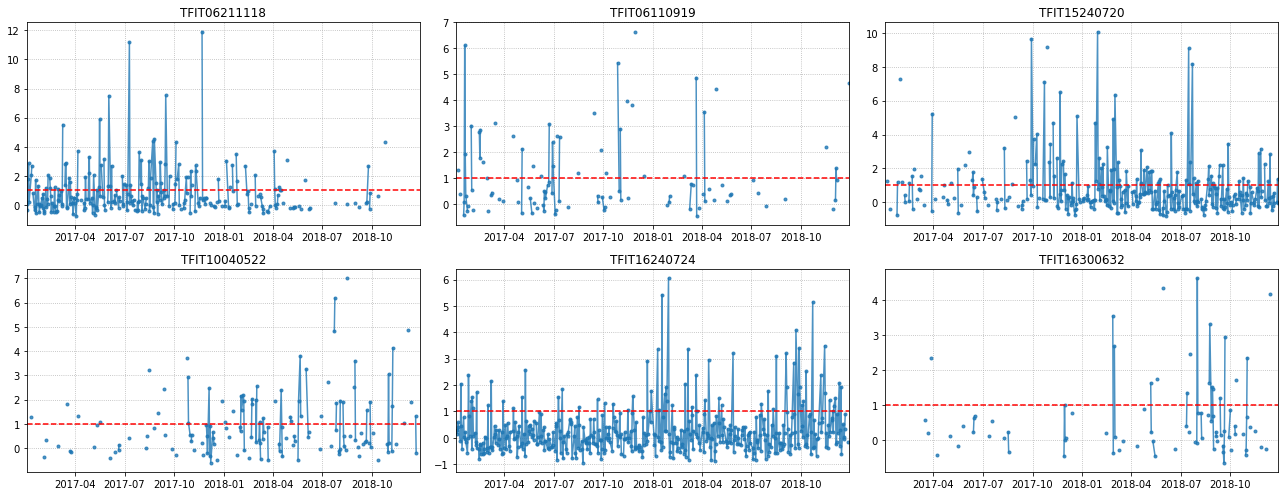

In [48]:
# Definimos una ruta donde guardaremos los resultados 
DIRECTORY  = "JS_freq_results"
PARENT_DIR = os.getcwd()
PATH       = os.path.join(PARENT_DIR, DIRECTORY)

fig = plt.figure(figsize=(18, 7))

ax1 = fig.add_subplot(231)
JS_data["30T"]["TFIT06211118"].plot(title="TFIT06211118", ax=ax1, alpha=0.8, marker=".")
ax1.axhline(1, linestyle="--", c="red")
ax1.grid(linestyle=":")

ax2 = fig.add_subplot(232)
JS_data["30T"]["TFIT06110919"].plot(title="TFIT06110919", ax=ax2, alpha=0.8, marker=".")
ax2.axhline(1, linestyle="--", c="red")
ax2.grid(linestyle=":")

ax3 = fig.add_subplot(233)
JS_data["30T"]["TFIT15240720"].plot(title="TFIT15240720", ax=ax3, alpha=0.8, marker=".")
ax3.axhline(1, linestyle="--", c="red")
ax3.grid(linestyle=":")

ax4 = fig.add_subplot(234)
JS_data["30T"]["TFIT10040522"].plot(title="TFIT10040522", ax=ax4, alpha=0.8, marker=".")
ax4.axhline(1, linestyle="--", c="red")
ax4.grid(linestyle=":")

ax5 = fig.add_subplot(235)
JS_data["30T"]["TFIT16240724"].plot(title="TFIT16240724", ax=ax5, alpha=0.8, marker=".")
ax5.axhline(1, linestyle="--", c="red")
ax5.grid(linestyle=":")

ax6 = fig.add_subplot(236)
JS_data["30T"]["TFIT16300632"].plot(title="TFIT16300632", ax=ax6, alpha=0.8, marker=".")
ax6.axhline(1, linestyle="--", c="red")
ax6.grid(linestyle=":")

plt.tight_layout()
#plt.savefig(PATH+"/all_30T.pdf")
plt.show()

# Co-saltos
---

En esta seccion unificamos los resultados de la excedencia del estadístico conjunta para todos los bonos y para todas las frecuencias

In [57]:
def find_cojumps(js_data, nemos):
    """
    ------------------------------------------------------
    Funcion que retorna un DataFrame con 3 resultados:
    Una columna con el cosalto (definido en Dungey et.al.)
    Una columna booleana indicando si hay o no hay cosalto
    Una columna con un contador de cosaltos
    ------------------------------------------------------
    
    """
    
    def cojump_data(js_data, nemos):
        co_jumps = dict()
        for k in js_data.keys():
            CJ = []
            for n in nemos:
                temp = np.where(js_data[k][n] >= 1, 1, 
                                np.where(np.isnan(js_data[k][n]), np.nan, 0) )
                dats = {n: temp}
                indx = js_data[k][n].index.tolist()
                
                CJ.append(pd.DataFrame(dats, index=indx))
            co_jumps[k] = pd.concat(CJ, axis=1)
            
        return co_jumps
    
    # Calculamos los cosaltos
    cj_data = cojump_data(js_data, nemos)
    
    # Inicializamos el diccionario donde guardamos el resultado final
    cj = dict()
    for k in cj_data.keys():
        
        # Filtramos los datos segun los nemos y contamos la cantidad de veces que se supera el salto
        # Si el valor es NaN se descarta ya que no se puede comprarar
        df = pd.DataFrame(cj_data[k][nemos].dropna().sum(axis=1), columns=[k])
        
        # Creamos una columna booleana que indica si hay un cosalto
        df["cojump"] = np.where(df.values ==2, 1, 0)
        
        # Vemos los saltos acumulados
        df["agg_cojump"] = df["cojump"].cumsum()
        
        cj[k] = df
    return cj

In [58]:
co_jump1  = find_cojumps(co_jumps, ['TFIT16240724', 'TFIT15240720'])
co_jump2  = find_cojumps(co_jumps, ['TFIT16240724', 'TFIT06211118'])
co_jump3  = find_cojumps(co_jumps, ['TFIT06211118', 'TFIT15240720'])

co_jump21 = find_cojumps(co_jumps, ['TFIT06211118', 'TFIT16300632'])
co_jump22 = find_cojumps(co_jumps, ['TFIT15240720', 'TFIT16300632'])
co_jump23 = find_cojumps(co_jumps, ['TFIT16240724', 'TFIT16300632'])

In [60]:
co_jump21["5T"].head()

,5T,cojump,agg_cojump
2017-03-10,2.0,1,1
2017-03-16,2.0,1,2
2017-03-22,2.0,1,3
2017-03-23,2.0,1,4
2017-03-27,2.0,1,5


In [61]:
# Funcion que adjunta los cosaltos acumulados para graficarlos

def aggregate_cojumps(js_data, nemos1, nemos2, nemos3):
    """
    -----------------------------------------------------------
    Funcion que permite hacer las graficas de evolucion temporal
    de los cosaltos
    -----------------------------------------------------------
    
    """
    
    # Encontramos los cosaltos para cada pareja descrita en los nemos
    cj_dict1 = find_cojumps(js_data, nemos1)
    cj_dict2 = find_cojumps(js_data, nemos2)
    cj_dict3 = find_cojumps(js_data, nemos3)
    
    # Inicializamos el diccionario donde guardaremos los resultados finales
    tot_cojumps = dict()
    
    for k in cj_dict1.keys():
        
        # Nos quedamos con la suma cumulativa de los cosaltos para cada pareja en nemos
        cj_dict1[k] = cj_dict1[k][["agg_cojump"]].copy()
        cj_dict1[k].columns = ["agg_cojump1"] # Suma acumulada de cosaltos de la pareja nemos1
        
        cj_dict2[k] = cj_dict2[k][["agg_cojump"]].copy()
        cj_dict2[k].columns = ["agg_cojump2"] # Suma acumulada de cosaltos de la pareja nemos2
        
        cj_dict3[k] = cj_dict3[k][["agg_cojump"]].copy()
        cj_dict3[k].columns = ["agg_cojump3"] # Suma acumulada de cosaltos de la pareja nemos3
        
        # Guardamos las sumas acumuladas para todas las frecuencias
        tot_cojumps[k] = pd.concat([cj_dict1[k], cj_dict2[k], cj_dict3[k]], sort=True, axis=1)
        
        # Llenamos los NaN arrastrando los valores anteriores
        tot_cojumps[k] = tot_cojumps[k].fillna(method="ffill")
    return tot_cojumps

In [62]:
total_cojumps1 = aggregate_cojumps(co_jumps, 
                                   ['TFIT16240724', 'TFIT15240720'], 
                                   ['TFIT16240724', 'TFIT06211118'], 
                                   ['TFIT06211118', 'TFIT15240720'])
total_cojumps2 = aggregate_cojumps(co_jumps, 
                                   ['TFIT06211118', 'TFIT16300632'], 
                                   ['TFIT15240720', 'TFIT16300632'], 
                                   ['TFIT16240724', 'TFIT16300632'])

In [68]:
total_cojumps1["5T"].head()

,agg_cojump1,agg_cojump2,agg_cojump3
2017-01-03,NaN,1.0,NaN
2017-01-04,NaN,1.0,NaN
2017-01-05,0.0,1.0,1.0
2017-01-06,0.0,1.0,1.0
2017-01-10,0.0,1.0,2.0


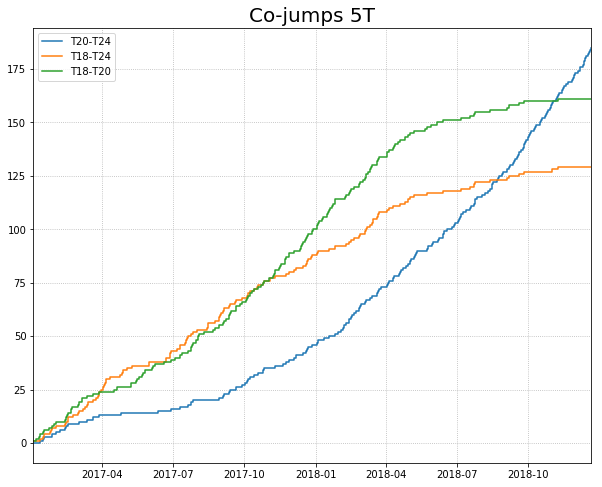

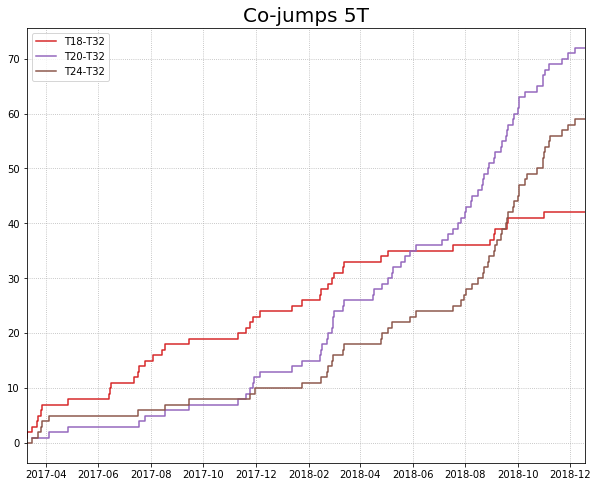

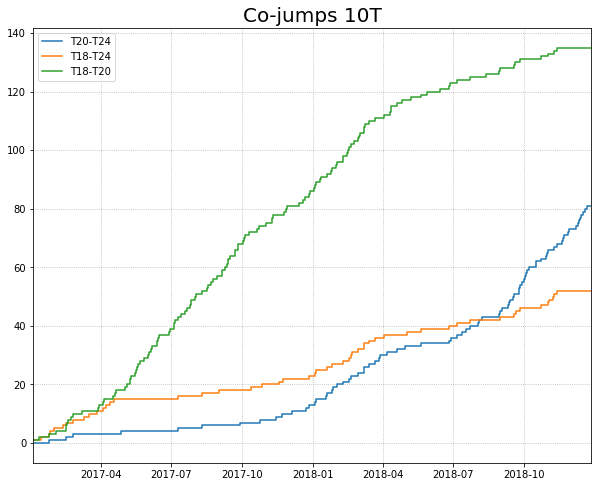

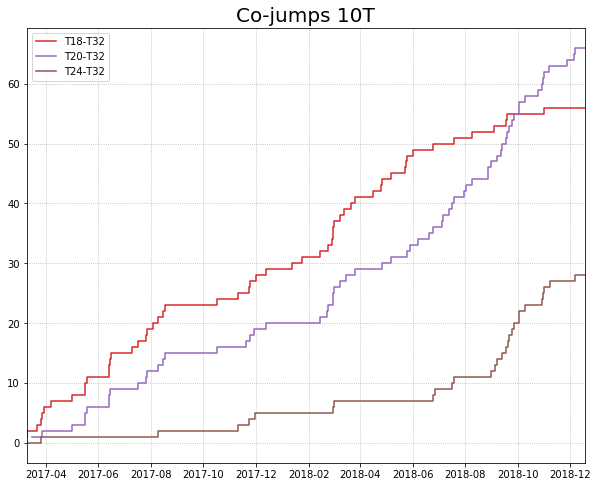

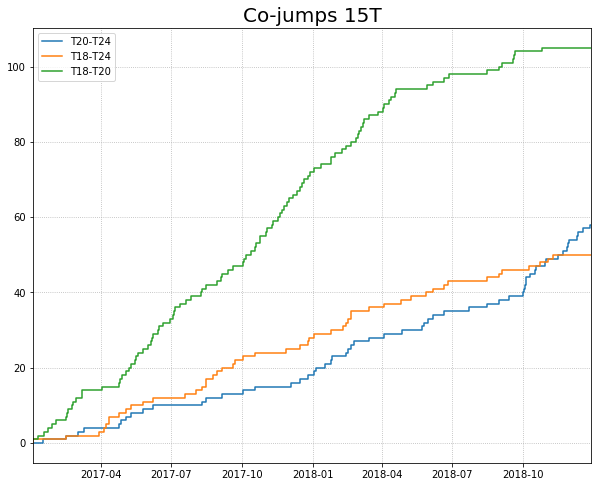

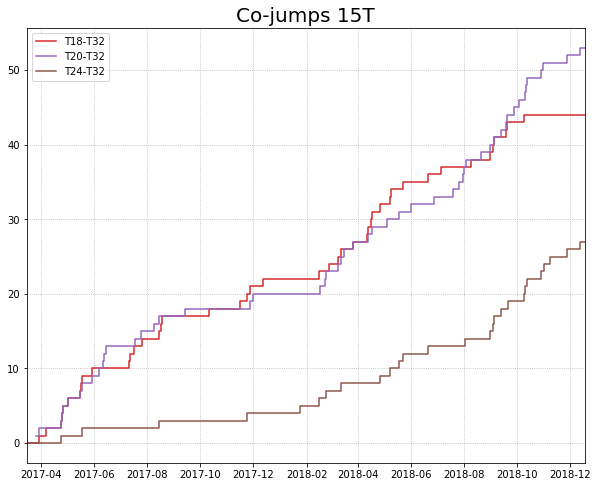

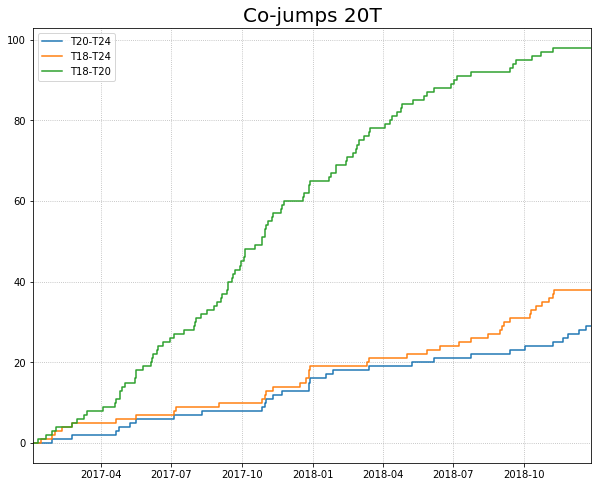

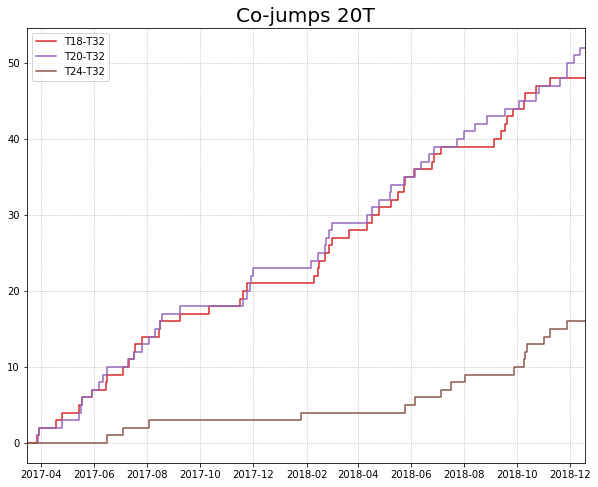

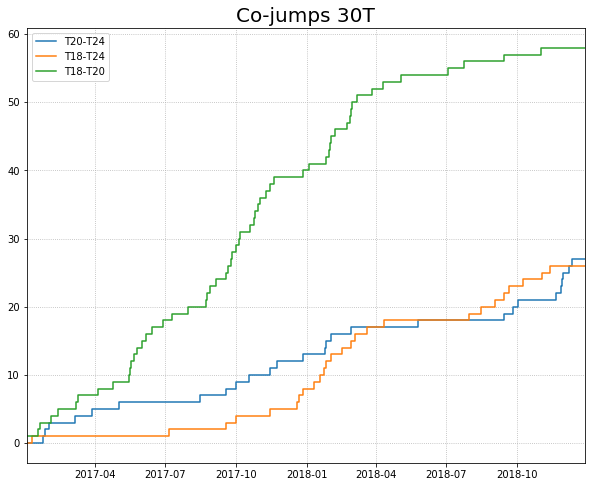

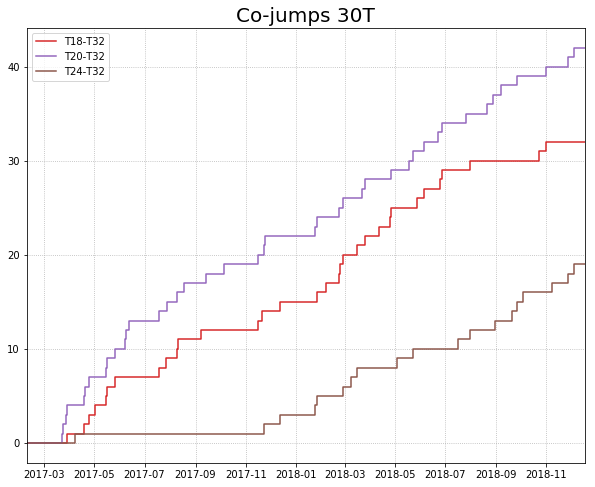

In [65]:
for k in co_jump1.keys():
    fig = plt.figure(figsize=(10, 8))
    ax  = fig.add_subplot(111)
    total_cojumps1[k].plot(y="agg_cojump1", figsize=(10, 8), ax=ax, label="T20-T24", drawstyle='steps')
    total_cojumps1[k].plot(y="agg_cojump2", figsize=(10, 8), ax=ax, label="T18-T24", drawstyle='steps')
    total_cojumps1[k].plot(y="agg_cojump3", figsize=(10, 8), ax=ax, label="T18-T20", drawstyle='steps')
    plt.grid(linestyle=":")
    plt.title("Co-jumps " + k, fontsize=20)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1  = fig1.add_subplot(111)
    total_cojumps2[k].plot(y="agg_cojump1", figsize=(10, 8), color="C3", ax=ax1, label="T18-T32", drawstyle='steps')
    total_cojumps2[k].plot(y="agg_cojump2", figsize=(10, 8), color="C4", ax=ax1, label="T20-T32", drawstyle='steps')
    total_cojumps2[k].plot(y="agg_cojump3", figsize=(10, 8), color="C5", ax=ax1, label="T24-T32", drawstyle='steps')
    plt.grid(linestyle=":")
    plt.title("Co-jumps " + k, fontsize=20)
plt.show()

**Figura 2:** Evolución temporal de los cosaltos

Esta figura va en la sección de resultados, sub-sección de cosaltos en el documento de la tesis

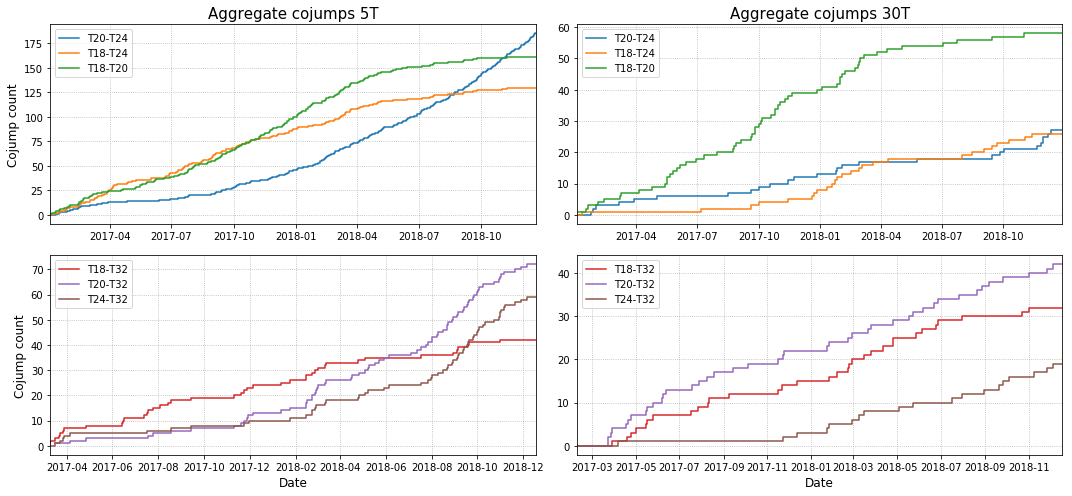

In [106]:
# Definimos una ruta donde guardaremos los resultados 
DIRECTORY  = "CoJump"
PARENT_DIR = os.getcwd()
PATH       = os.path.join(PARENT_DIR, DIRECTORY)

# Creamos el directorio donde guardaremos las bases de datos
#os.mkdir(PATH) # Si el directorio ya existe este comando bota error

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(221)
total_cojumps1["5T"].plot(y="agg_cojump1", ax=ax1, label="T20-T24", drawstyle='steps')
total_cojumps1["5T"].plot(y="agg_cojump2", ax=ax1, label="T18-T24", drawstyle='steps')
total_cojumps1["5T"].plot(y="agg_cojump3", ax=ax1, label="T18-T20", drawstyle='steps')
ax1.grid(linestyle=":")
ax1.set_title("Aggregate cojumps 5T", fontsize=15)
ax1.set_ylabel("Cojump count", fontsize=12)

ax2 = fig.add_subplot(222)
total_cojumps1["30T"].plot(y="agg_cojump1", ax=ax2, label="T20-T24", drawstyle='steps')
total_cojumps1["30T"].plot(y="agg_cojump2", ax=ax2, label="T18-T24", drawstyle='steps')
total_cojumps1["30T"].plot(y="agg_cojump3", ax=ax2, label="T18-T20", drawstyle='steps')
ax2.grid(linestyle=":")
ax2.set_title("Aggregate cojumps 30T", fontsize=15)

ax3 = fig.add_subplot(223)
total_cojumps2["5T"].plot(y="agg_cojump1", color="C3", ax=ax3, label="T18-T32", drawstyle='steps')
total_cojumps2["5T"].plot(y="agg_cojump2", color="C4", ax=ax3, label="T20-T32", drawstyle='steps')
total_cojumps2["5T"].plot(y="agg_cojump3", color="C5", ax=ax3, label="T24-T32", drawstyle='steps')
ax3.grid(linestyle=":")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Cojump count", fontsize=12)

ax4 = fig.add_subplot(224)
total_cojumps2["30T"].plot(y="agg_cojump1", color="C3", ax=ax4, label="T18-T32", drawstyle='steps')
total_cojumps2["30T"].plot(y="agg_cojump2", color="C4", ax=ax4, label="T20-T32", drawstyle='steps')
total_cojumps2["30T"].plot(y="agg_cojump3", color="C5", ax=ax4, label="T24-T32", drawstyle='steps')
ax4.grid(linestyle=":")
ax4.set_xlabel("Date", fontsize=12)

plt.tight_layout()
#plt.savefig(PATH+"/cojump.pdf")
plt.show()